In [1]:
import numpy as np
import matplotlib.pyplot as plt


# from hnc_custom_screeningOZ_multiscale import  HNC_solver
from hnc_Ng import  HNC_solver
from qsps import *

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
        
        
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
# N_bins, R_max = 500, 3 

In [58]:
def run_hnc(n_in_per_cc, T, Z, A, Zstar, num_iterations=1e3, alpha_Picard = 1e-3, alpha_Ng = 1e-3, tol=1e-8, c_k_guess=None , which_Tij='thermal',
            oz_type='standard', method='best', add_bridge=False, bridge='yukawa' , pseudopotential=False, 
            r_c=0.6, nums_to_use=5):
    n_in_AU = n_in_per_cc*1e6 *aB**3
    ri = QSP_HNC.rs_from_n(n_in_AU)
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri, Zstar*n_in_AU, which_Tij=which_Tij, r_c=r_c)

    N_species = 2
    Gamma = np.array(  [[qsp.Γii,  qsp.Γei],
                        [qsp.Γei,  qsp.Γee]])


    names = ["Ion-1", "Electron", ] 
    kappa = 1
    rhos = np.array([  3/(4*np.pi), Zstar*3/(4*np.pi) ])
    temps = np.array([qsp.Ti, qsp.Te_c])
    masses= np.array([qsp.m_i, m_e])
    hnc1 = HNC_solver(N_species, Gamma, rhos, temps, masses , tol=tol,
                     kappa_multiscale=5, num_iterations=int(num_iterations), 
                     R_max=R_max, N_bins=N_bins, names=names, dst_type=3, oz_method=oz_type, h_max=1e8)

    if pseudopotential==True:
        βvei = qsp.βvei_atomic(hnc1.r_array)
    else:
        βvei = qsp.βvei(hnc1.r_array)
    βu_r_matrix = np.array([[qsp.βvii(hnc1.r_array), βvei],
                            [βvei, qsp.βvee(hnc1.r_array)]])

    if add_bridge:
        if bridge=='ocp':
            βu_r_matrix[0,0] = βu_r_matrix[0,0] - hnc1.Bridge_function_OCP(hnc1.r_array, qsp.Γii)
        elif bridge=='yukawa':
            βu_r_matrix[0,0] = βu_r_matrix[0,0] - hnc1.Bridge_function_Yukawa(hnc1.r_array, qsp.Γii, qsp.get_κ())
    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    if c_k_guess is not None:
        for i in range(N_species):
            for j in range(N_species):
                if (c_k_guess[i,j]!=np.zeros(hnc1.N_bins)).all():
#                 if i==j:
                    hnc1.c_k_matrix[i,j] = c_k_guess[i,j]
                    hnc1.c_r_matrix[i,j] = hnc1.FT_k_2_r(hnc1.c_k_matrix[i,j])
                    hnc1.c_s_k_matrix[i,j] = hnc1.c_k_matrix[i,j] + hnc1.βu_l_k_matrix[i,j]
                    hnc1.c_s_r_matrix[i,j] = hnc1.c_r_matrix[i,j] + hnc1.βu_l_r_matrix[i,j]

#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    hnc1.set_C_matrix()
    hnc1.HNC_solve(alpha_method=method, iters_to_use=nums_to_use, alpha_Ng=alpha_Ng, alpha_Picard = alpha_Picard,
                   alpha_oz = 0e-4,iters_to_wait=100)
#     print(hnc1.HNC_newton_solve())

    return hnc1, qsp

# Priority 1

## atom

In [59]:
mixture_file = "/home/zach/plasma/hnc/data/TCCW_single_species_data.csv"
tccw_mixture_data = read_csv(mixture_file)
tccw_cases = [tccw_mixture_data.iloc[n] for n in range(len(tccw_mixture_data))]

case_successes = {}
SVT_case_successes = {}
R_max = 5
N_bins = 500
max_attempts=1

tccw_case = tccw_cases[2]
α = 0.1
case_converged=False
case_attempts=0
case_num= tccw_case[' ']
case_id = tccw_case['Case ID']
ni = tccw_case['Number Density [N/cc]']
Te = tccw_case['Temperature [eV]']*eV
Ti = Te
Z = tccw_case['Atomic Number']
Zstar = tccw_case['Zbar (TF)']
A = tccw_case['Atomic Weight [a.u.]']
r_s = tccw_case['Wigner-Seitz Radius [cm]']
r_c = tccw_case['Average-Bound Radius [cm]']/r_s

print('\n______________________________\nCase num: {0} Case ID: {1}'.format(case_num, case_id))
print("Te = {0:.3e} eV, n_i = {1:.3e} 1/cc, r_c/r_s = {2:.3f}".format(Te/eV, ni, r_c))



______________________________
Case num: 2 Case ID: Al1
Te = 1.000e+00 eV, n_i = 6.030e+22 1/cc, r_c/r_s = 0.217


In [60]:
# ni = 6.03e22 # per cc, rs=3
# Te = 1*eV 
# Ti   = 1*eV 
# Z, A = 13,27
# Zstar= 3

In [62]:
atom, atomqsp = run_hnc(ni, Te, Z, A, Zstar, num_iterations=1e3, method='fixed', 
                                tol=1e-8,  alpha_Picard=1e-1, alpha_Ng = 1e-8, pseudopotential=True, oz_type='standard',r_c=0.217,
                                  nums_to_use = 5, add_bridge=True)
# atom, atomqsp = run_hnc(ni, Te, Z, A, Zstar, num_iterations=1e3, method='fixed', 
#                                 tol=1e-8,  alpha=1e-1, pseudopotential=True, oz_type='svt',r_c=0.217,
#                                 nums_to_use = 1e4)

Λei = 0.222
Λee = 0.313
Λei adjusted with R = 0.222
Γii=81.917, Γie=-2.769, Γee=0.923 
r_i=2.989
r_e=2.073
r_c=0.217
θ  =8.57e-02
0: Change in c_r: 4.048e-02, HNC Error: 9.685e+04, Total Error: 1.638e+02
1: Change in c_r: 3.987e-02, HNC Error: 4.329e+03, Total Error: 1.502e+02
2: Change in c_r: 3.934e-02, HNC Error: 6.851e+02, Total Error: 1.377e+02
3: Change in c_r: 3.886e-02, HNC Error: 2.011e+02, Total Error: 1.262e+02
4: Change in c_r: 3.840e-02, HNC Error: 8.362e+01, Total Error: 1.156e+02
5: Change in c_r: 3.797e-02, HNC Error: 4.308e+01, Total Error: 1.060e+02
6: Change in c_r: 3.757e-02, HNC Error: 2.556e+01, Total Error: 9.710e+01
7: Change in c_r: 3.719e-02, HNC Error: 1.670e+01, Total Error: 8.899e+01
8: Change in c_r: 3.683e-02, HNC Error: 1.170e+01, Total Error: 8.155e+01
9: Change in c_r: 3.649e-02, HNC Error: 8.625e+00, Total Error: 7.475e+01
10: Change in c_r: 3.617e-02, HNC Error: 6.608e+00, Total Error: 6.852e+01
11: Change in c_r: 3.587e-02, HNC Error: 5.216e+00, Tot

107: Change in c_r: 2.535e-02, HNC Error: 3.349e+00, Total Error: 9.793e-01
108: Change in c_r: 2.434e-02, HNC Error: 3.484e+00, Total Error: 9.669e-01
109: Change in c_r: 2.417e-02, HNC Error: 3.625e+00, Total Error: 9.548e-01
110: Change in c_r: 1.685e+00, HNC Error: 5.912e-01, Total Error: 2.598e+00
111: Change in c_r: 1.855e+00, HNC Error: 4.796e+00, Total Error: 8.849e-01
112: Change in c_r: 2.412e-02, HNC Error: 4.994e+00, Total Error: 8.742e-01
113: Change in c_r: 2.342e-02, HNC Error: 5.196e+00, Total Error: 8.635e-01
114: Change in c_r: 2.318e-02, HNC Error: 5.404e+00, Total Error: 8.531e-01
115: Change in c_r: 1.626e+00, HNC Error: 7.522e-01, Total Error: 2.147e+00
116: Change in c_r: 1.791e+00, HNC Error: 7.275e+00, Total Error: 7.771e-01
117: Change in c_r: 2.304e-02, HNC Error: 7.576e+00, Total Error: 7.679e-01
118: Change in c_r: 2.246e-02, HNC Error: 7.883e+00, Total Error: 7.590e-01
119: Change in c_r: 2.219e-02, HNC Error: 8.197e+00, Total Error: 7.504e-01
120: Change 

216: Change in c_r: 6.703e-01, HNC Error: 1.727e+03, Total Error: 1.326e-01
217: Change in c_r: 8.598e-03, HNC Error: 1.752e+03, Total Error: 1.316e-01
218: Change in c_r: 8.402e-03, HNC Error: 1.777e+03, Total Error: 1.307e-01
219: Change in c_r: 7.690e-03, HNC Error: 1.800e+03, Total Error: 1.298e-01
220: Change in c_r: 5.786e-01, HNC Error: 6.540e+02, Total Error: 2.023e-01
221: Change in c_r: 6.348e-01, HNC Error: 1.979e+03, Total Error: 1.235e-01
222: Change in c_r: 8.184e-03, HNC Error: 2.006e+03, Total Error: 1.226e-01
223: Change in c_r: 7.955e-03, HNC Error: 2.033e+03, Total Error: 1.217e-01
224: Change in c_r: 7.226e-03, HNC Error: 2.058e+03, Total Error: 1.209e-01
225: Change in c_r: 5.478e-01, HNC Error: 7.982e+02, Total Error: 1.872e-01
226: Change in c_r: 6.009e-01, HNC Error: 2.248e+03, Total Error: 1.151e-01
227: Change in c_r: 7.785e-03, HNC Error: 2.278e+03, Total Error: 1.143e-01
228: Change in c_r: 7.500e-03, HNC Error: 2.306e+03, Total Error: 1.135e-01
229: Change 

324: Change in c_r: 2.207e-03, HNC Error: 8.867e+03, Total Error: 3.178e-02
325: Change in c_r: 1.730e-01, HNC Error: 6.835e+03, Total Error: 4.678e-02
326: Change in c_r: 1.896e-01, HNC Error: 9.086e+03, Total Error: 3.039e-02
327: Change in c_r: 2.529e-03, HNC Error: 9.119e+03, Total Error: 3.019e-02
328: Change in c_r: 2.319e-03, HNC Error: 9.150e+03, Total Error: 2.999e-02
329: Change in c_r: 2.079e-03, HNC Error: 9.179e+03, Total Error: 2.981e-02
330: Change in c_r: 1.631e-01, HNC Error: 7.192e+03, Total Error: 4.382e-02
331: Change in c_r: 1.787e-01, HNC Error: 9.391e+03, Total Error: 2.852e-02
332: Change in c_r: 2.384e-03, HNC Error: 9.425e+03, Total Error: 2.832e-02
333: Change in c_r: 2.186e-03, HNC Error: 9.453e+03, Total Error: 2.814e-02
334: Change in c_r: 1.960e-03, HNC Error: 9.481e+03, Total Error: 2.798e-02
335: Change in c_r: 1.537e-01, HNC Error: 7.544e+03, Total Error: 4.106e-02
336: Change in c_r: 1.684e-01, HNC Error: 9.687e+03, Total Error: 2.676e-02
337: Change 

432: Change in c_r: 7.391e-04, HNC Error: 1.349e+04, Total Error: 8.276e-03
433: Change in c_r: 6.571e-04, HNC Error: 1.354e+04, Total Error: 8.124e-03
434: Change in c_r: 5.946e-04, HNC Error: 1.354e+04, Total Error: 8.146e-03
435: Change in c_r: 4.691e-02, HNC Error: 1.269e+04, Total Error: 1.170e-02
436: Change in c_r: 5.138e-02, HNC Error: 1.362e+04, Total Error: 7.817e-03
437: Change in c_r: 6.713e-04, HNC Error: 1.364e+04, Total Error: 7.825e-03
438: Change in c_r: 6.527e-04, HNC Error: 1.363e+04, Total Error: 7.729e-03
439: Change in c_r: 5.497e-04, HNC Error: 1.367e+04, Total Error: 7.661e-03
440: Change in c_r: 4.420e-02, HNC Error: 1.285e+04, Total Error: 1.102e-02
441: Change in c_r: 4.841e-02, HNC Error: 1.375e+04, Total Error: 7.359e-03
442: Change in c_r: 6.386e-04, HNC Error: 1.379e+04, Total Error: 7.212e-03
443: Change in c_r: 5.960e-04, HNC Error: 1.376e+04, Total Error: 7.318e-03
444: Change in c_r: 5.395e-04, HNC Error: 1.378e+04, Total Error: 7.197e-03
445: Change 

540: Change in c_r: 1.353e-02, HNC Error: 1.487e+04, Total Error: 3.129e-03
541: Change in c_r: 1.487e-02, HNC Error: 1.508e+04, Total Error: 2.055e-03
542: Change in c_r: 5.439e-04, HNC Error: 1.409e+04, Total Error: 6.561e-03
543: Change in c_r: 3.202e-04, HNC Error: 1.531e+04, Total Error: 2.300e-03
544: Change in c_r: 2.861e-04, HNC Error: 1.503e+04, Total Error: 2.510e-03
545: Change in c_r: 1.266e-02, HNC Error: 1.481e+04, Total Error: 3.106e-03
546: Change in c_r: 1.394e-02, HNC Error: 1.486e+04, Total Error: 3.024e-03
547: Change in c_r: 7.811e-04, HNC Error: 1.537e+04, Total Error: 6.663e-03
548: Change in c_r: 1.393e-03, HNC Error: 1.430e+04, Total Error: 5.658e-03
549: Change in c_r: 5.103e-04, HNC Error: 1.526e+04, Total Error: 2.190e-03
550: Change in c_r: 1.190e-02, HNC Error: 1.485e+04, Total Error: 3.191e-03
551: Change in c_r: 1.295e-02, HNC Error: 1.532e+04, Total Error: 2.904e-03
552: Change in c_r: 3.196e-04, HNC Error: 1.665e+04, Total Error: 6.151e-03
553: Change 

650: Change in c_r: 6.232e-03, HNC Error: 1.782e+04, Total Error: 1.048e-02
651: Change in c_r: 1.020e-02, HNC Error: 1.304e+04, Total Error: 4.910e-02
652: Change in c_r: 1.482e-02, HNC Error: 1.207e+03, Total Error: 2.077e-01
653: Change in c_r: 1.289e-02, HNC Error: 2.201e+04, Total Error: 1.214e-01
654: Change in c_r: 1.732e-02, HNC Error: 1.257e+04, Total Error: 1.907e-02
655: Change in c_r: 2.878e-03, HNC Error: 1.315e+04, Total Error: 1.819e-02
656: Change in c_r: 4.876e-03, HNC Error: 7.581e+03, Total Error: 5.501e-02
657: Change in c_r: 3.382e-02, HNC Error: 4.298e+04, Total Error: 2.247e-01
658: Change in c_r: 4.974e-02, HNC Error: 1.673e+03, Total Error: 1.840e-01
659: Change in c_r: 2.363e-02, HNC Error: 2.146e+04, Total Error: 3.214e-02
660: Change in c_r: 2.759e-03, HNC Error: 1.355e+04, Total Error: 1.492e-02
661: Change in c_r: 7.619e-03, HNC Error: 2.606e+04, Total Error: 7.405e-02
662: Change in c_r: 1.166e-02, HNC Error: 1.285e+06, Total Error: 2.927e-01
663: Change 

/home/zach/plasma/hnc/hnc_Ng.py:472: RuntimeWarning: overflow encountered in exp
  hnc_err = np.linalg.norm(- 1 - self.h_r_matrix   + np.exp( -self.βu_r_matrix + self.h_r_matrix - self.c_r_matrix ))/np.sqrt(self.N_bins*self.N_species**2)


(0.2, 0.3)

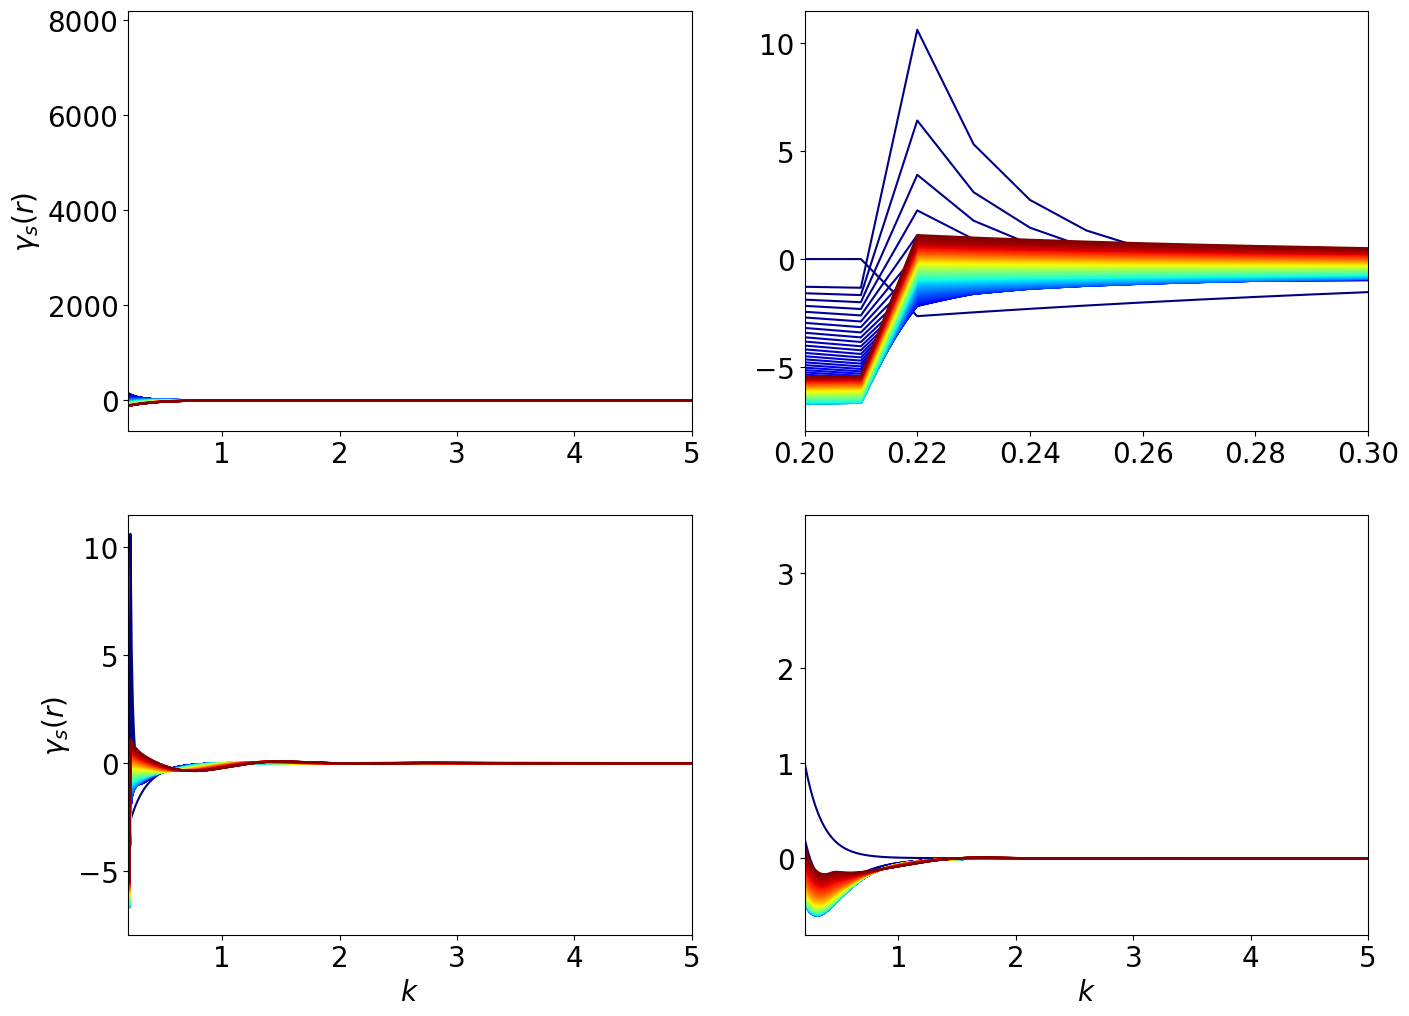

In [51]:
fig, axs = plt.subplots(2,2, figsize=(16,12))
# axs=np.array([[axs]])
c_s_r_matrix_list = np.array([atom.FT_k_2_r_matrix(c_s_k_matrix) for c_s_k_matrix in atom.c_s_k_matrix_list])
γs_matrix_list = np.array(atom.h_r_matrix_list)-c_s_r_matrix_list
for i in range(2):
        for j in range(2):
            for k in range(216):
                color = plt.cm.jet(k/216)
                axs[i,j].plot(atom.r_array, γs_matrix_list[k][i,j], color=color)

            axs[-1,j].set_xlabel(r"$r/r_s$",fontsize=20)
#             axs[i,j].set_xscale('log')
            axs[i,j].set_xlim(0.2,5)
            axs[i,j].tick_params(labelsize=20)
            axs[-1,j].set_xlabel(r"$k $",fontsize=20)
#             axs[i,j].set_yscale('symlog',linthresh=0.1)
#             axs[i,j].set_ylim(-10, 1e1)

        axs[i,0].set_ylabel(r"$\gamma_s(r)$",fontsize=20)
axs[0,1].set_xlim(0.2,0.3)
# axs[0,0].set_xlim(0,0.3)
    

(0.0, 1.0)

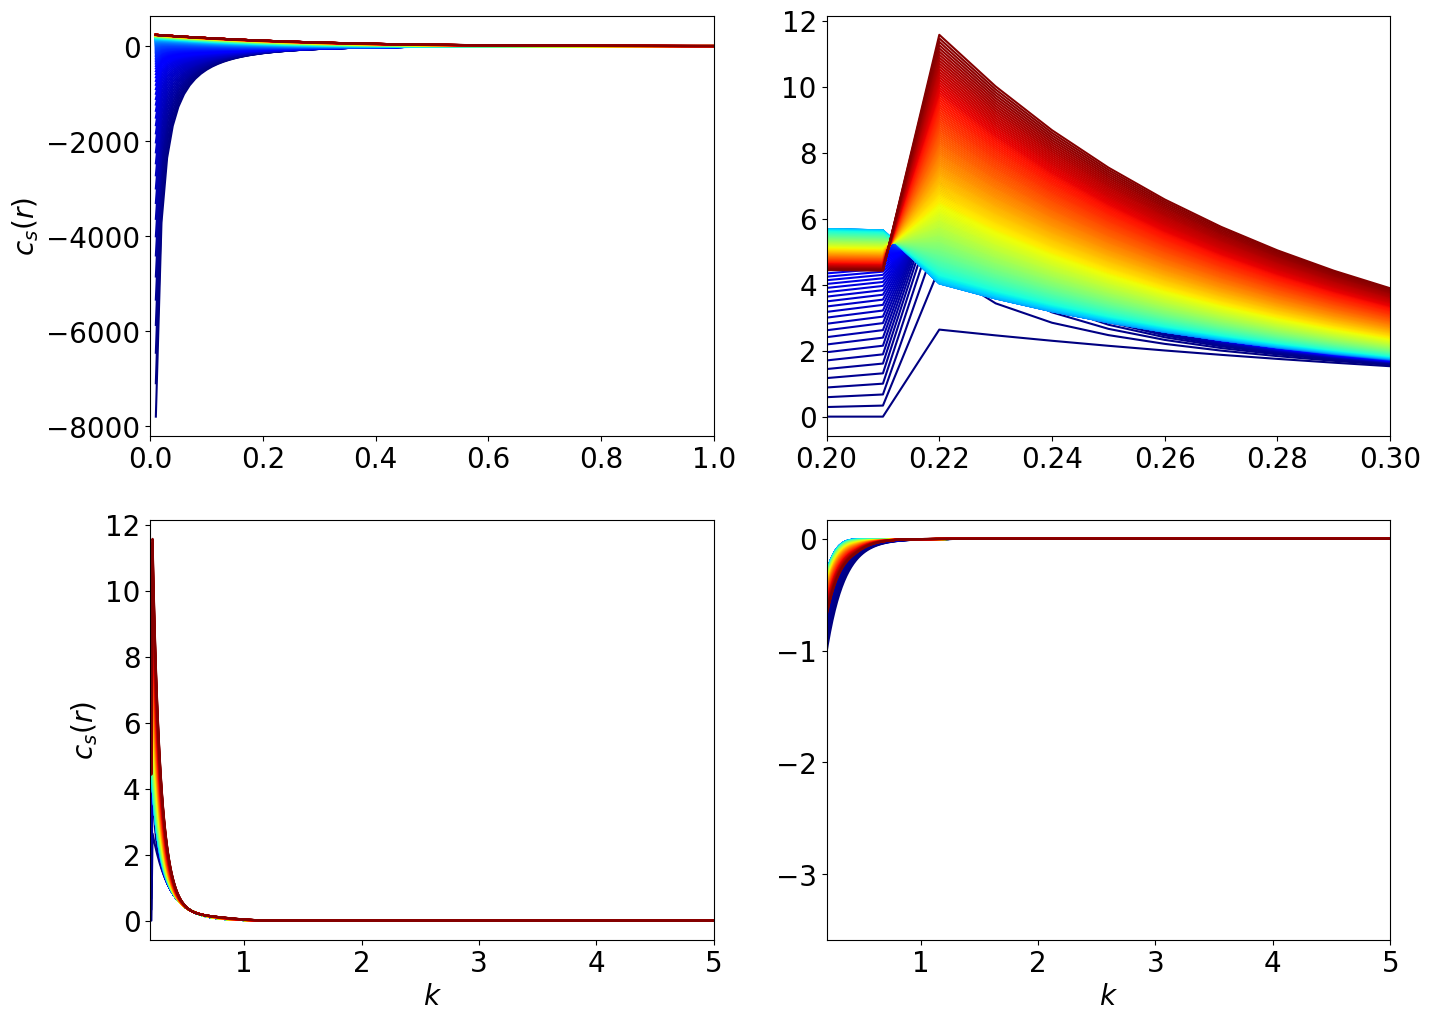

In [52]:
fig, axs = plt.subplots(2,2, figsize=(16,12))
# axs=np.array([[axs]])
c_s_r_matrix_list = np.array([atom.FT_k_2_r_matrix(c_s_k_matrix) for c_s_k_matrix in atom.c_s_k_matrix_list])
γs_matrix_list = np.array(atom.h_r_matrix_list)-c_s_r_matrix_list
for i in range(2):
        for j in range(2):
            for k in range(216):
                color = plt.cm.jet(k/216)
                axs[i,j].plot(atom.r_array, c_s_r_matrix_list[k][i,j], color=color)

            axs[-1,j].set_xlabel(r"$r/r_s$",fontsize=20)
#             axs[i,j].set_xscale('log')
            axs[i,j].set_xlim(0.2,5)
            axs[i,j].tick_params(labelsize=20)
            axs[-1,j].set_xlabel(r"$k $",fontsize=20)
#             axs[i,j].set_yscale('symlog',linthresh=0.1)
#             axs[i,j].set_ylim(-10, 1e1)

        axs[i,0].set_ylabel(r"$c_s(r)$",fontsize=20)
axs[0,1].set_xlim(0.2,0.3)
axs[0,0].set_xlim(0,1)
    

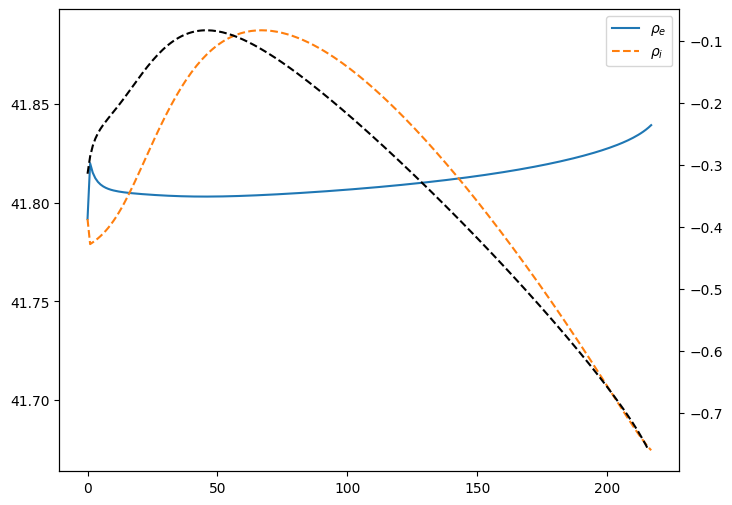

In [53]:
fig, ax = plt.subplots(1,1, figsize=(8,6))


ρ_e = [ np.sum(((h_r_matrix[0,1]+1)*atom.r_array**2)*atom.del_r) for h_r_matrix in atom.h_r_matrix_list]
ρ_i = [ np.sum(((h_r_matrix[0,0]+1)*atom.r_array**2)*atom.del_r) for h_r_matrix in atom.h_r_matrix_list]

ax.plot(ρ_e ,label=r'$\rho_e$')#, color=color)
ax.plot(ρ_i,  '--', label=r'$\rho_i$')#,color=color)
ax2 = ax.twinx()
ax2.plot(atom.u_ex_list,'--k')
# axs[-1,j].set_xlabel(r"$r/r_s$",fontsize=20)
# #             axs[i,j].set_xscale('log')
# axs[i,j].set_xlim(0.2,5)
# axs[i,j].tick_params(labelsize=20)
# axs[-1,j].set_xlabel(r"$k $",fontsize=20)
# #             axs[i,j].set_yscale('symlog',linthresh=0.1)
# #             axs[i,j].set_ylim(-10, 1e1)

# axs[i,0].set_ylabel(r"$c_s(r)$",fontsize=20)
# axs[0,1].set_xlim(0.2,0.3)
# axs[0,0].set_xlim(0,1)
ax.legend()

In [ ]:
atom.plot_species_convergence_g(n_slices= int(len(atom.h_r_matrix_list)/1)  )
atom.plot_species_convergence_c(n_slices= int(len(atom.h_r_matrix_list)/1)  )
atom.plot_species_convergence_ck(n_slices= int(len(atom.h_r_matrix_list)/1)  )

In [55]:
Al_file = "/home/zach/plasma/datasets/RDFs/Al_1.0eV_rs3_VASP.txt"  # 1 eV
Al_file = '/home/zach/plasma/datasets/RDFs/Al_0.5eV_rs3_KS-MD.txt' # 0.5 eV
Al_data = read_csv(Al_file,header=0, names=['r','g'])

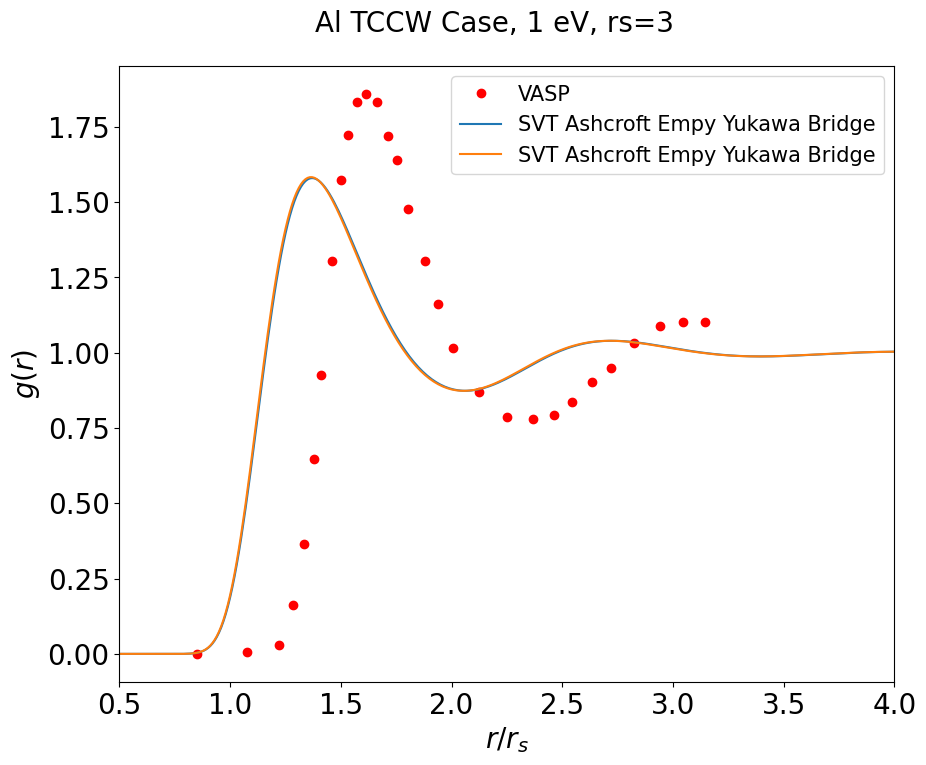

In [56]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Al TCCW Case, 1 eV, rs=3', fontsize=20, y=0.95)

ax.plot(Al_data['r'], Al_data['g'],'ro', label = 'VASP' )
# ax.plot(atom.r_array, atom_one_species.h_r_matrix[0,0] + 1, label='No electrons')
ax.plot(atom.r_array, atom.h_r_matrix_list[-1][0,0] + 1, label='SVT Ashcroft Empy Yukawa Bridge')
ax.plot(atom.r_array, atom.h_r_matrix_list[-2][0,0] + 1, label='SVT Ashcroft Empy Yukawa Bridge')
# ax.plot(atom.r_array, atomSVT.h_r_matrix[0,0] + 1, label='SVT Ashcroft')
# ax.plot(atom.r_array, atomSVT_Yuk.h_r_matrix[0,0] + 1,'--', label='SVT Ashcroft + Yukawa Bridge')
# ax.plot(atom.r_array, atomSVT_OCP.h_r_matrix[0,0] + 1,'--', label='SVT Ashcroft + OCP Bridge')

ax.set_ylabel(r'$g(r)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(0.5,4)
ax.legend(fontsize=15)
